## Debugging and testing ML pipeline

In [1]:
import time
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
import seaborn as sns

### Load json file in a dataframe

In [2]:
# paths
path_to_json_file = os.path.abspath('../data/json/')

# json file
json_file = '/all_parsed_data_json' #name json file  
file = '{}{}.json'.format(path_to_json_file, json_file)

In [3]:
# load json file
df = pd.read_json(file)

In [ ]:
# print(df.memory_usage(deep=True))
# df.info(verbose=True)

In [ ]:
# df.nunique()

## df setup
- Change data types & optimize memory usage
- Extract year
- Clean /n in text

In [4]:
# Change data types: Dates
columns_dates = ['study_first_submitted', 'study_first_posted', 'last_update_submitted', 'last_update_posted', 'verification_date']
for col in columns_dates:
    df[col] = df[col].astype('datetime64')

In [5]:
# # check
# for i in columns_dates:
#     print(df[i].dtypes)

In [6]:
# Extract year 
df['year_submitted'] = df['study_first_submitted'].dt.year
df['year_last_updated'] = df['last_update_submitted'].dt.year

In [7]:
# Remove /n
df = df.replace(r'\n',' ', regex=True)

In [ ]:
#check dataset
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_columns', 500)
# df.sample(1)

In [57]:
# Put all texts in a single column
df['all_text'] = df['brief_title'] + df['condition'] + df['condition_browse/mesh_term'] + df['intervention_browse/mesh_term'] + df['detailed_description/textblock'] + df['brief_summary/textblock']
df['all_text'][0]

'Erlotinib and Standard Platinum-Based Chemotherapy for Newly Diagnosed, Advanced Non-Small Cell Carcinoma of the LungCarcinoma, Non-Small-Cell LungCarcinomaPaclitaxel       To compare the activities (the progression-free survival, the incidence and severity of       toxicities, and reversibility of toxicities) of erlotinib to that of platinum-based therapy       in NSCLC. A sequential therapy design has been chosen such that all patients will receive any       potential benefits of both platinum-based and erlotinib therapy, without compromising       survival by denying anyone potential therapy. With this design, progression-free survival       will be tracked by treatment received. However, data will be generated which will show the       safety and efficacy of erlotinib in the frontline setting (alone and with historical       comparison to platinum-based therapy), as well as the potential safety and activity of       platinum-based therapy in the "second-line" (post-erlotinib) sett

### Basic analysis

In [8]:
# Plot variables plt
blue = '#3298D0'
base_color = ['#3298D0', '#d7191c', '#ffffbf']
plot_size = (16, 12)

In [9]:
# Plot variables sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "arial"

(1998, 2020)

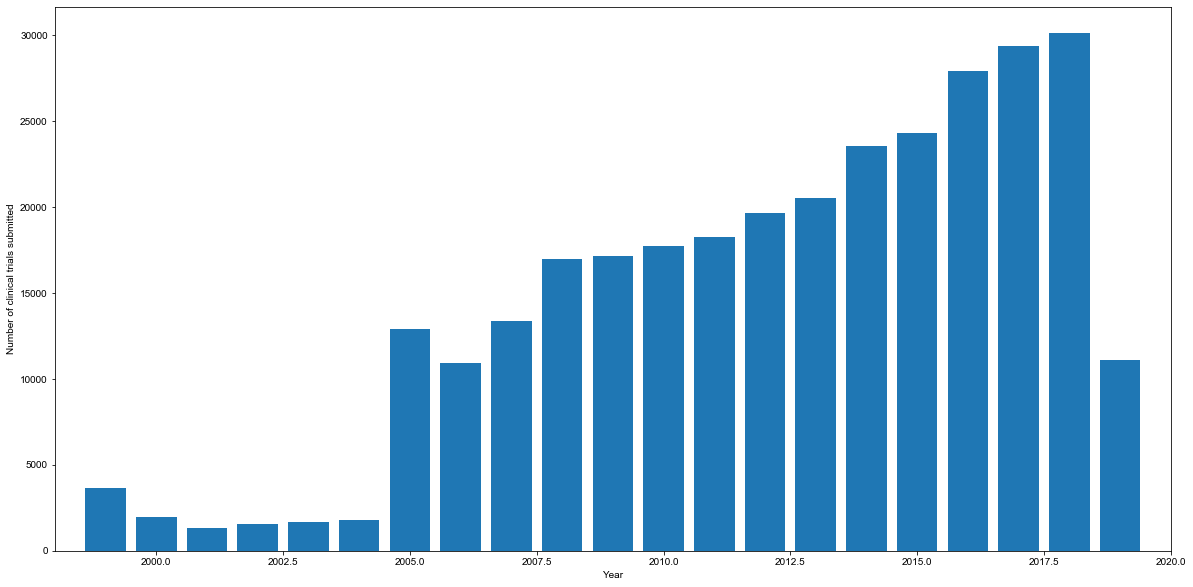

In [10]:
#trials per year -matplotlib
trials_per_year = df.groupby('year_submitted').nct_id.count()

plt.bar(trials_per_year.index, trials_per_year)
plt.xlabel('Year')
plt.ylabel('Number of clinical trials submitted')
plt.xlim(1998, 2020)

In [11]:
# group by two groups: year submitted, agency class
trials_year_status = df.groupby(['year_submitted','sponsors/lead_sponsor/agency_class']).nct_id.count()
trials_year_status['total'] = trials_year_status.sum()
trials_year_status.head()

year_submitted  sponsors/lead_sponsor/agency_class
1999            Industry                               517
                NIH                                   1586
                Other                                 1527
                U.S. Fed                                15
2000            Industry                                98
Name: nct_id, dtype: int64

In [12]:
# group by sponsor total -sns
sponsor = df.groupby(['sponsors/lead_sponsor/agency_class']).nct_id.count()
sponsor['total'] = sponsor.sum()
sponsor = pd.Series.to_frame(sponsor)

In [13]:
#add percentage
sponsor ['percentage'] = round(sponsor.nct_id / sponsor.nct_id.total * 100)

/Users/cms/Sites/env/haden/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


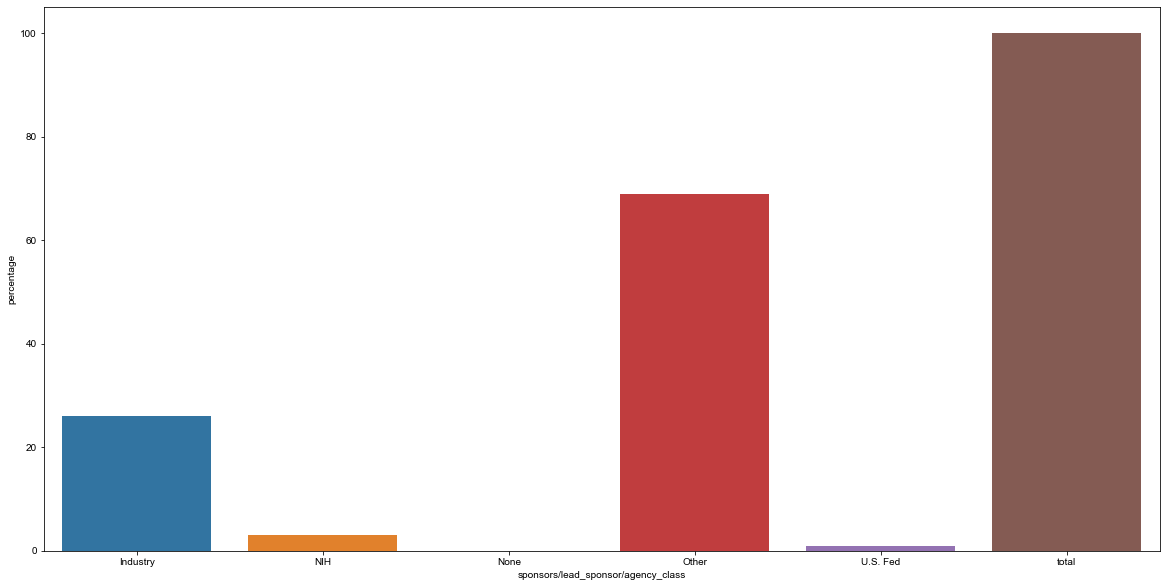

In [14]:
sponsor.loc[['nct_id', 'total']]
sns.barplot(x=sponsor.index, y=sponsor.percentage, data=sponsor)

## Conditions & mesh terms exploration

In [15]:
# Most frequent conditions
conditions = df.groupby('condition').nct_id.count()
conditions = pd.Series.to_frame(conditions)
conditions.sort_values('nct_id', ascending=False).head(10)

,nct_id
condition,
Healthy,6546
Breast Cancer,4609
Obesity,3039
HIV Infections,2469
Asthma,2454
Prostate Cancer,2386
Hypertension,1996
Schizophrenia,1964
Coronary Artery Disease,1830


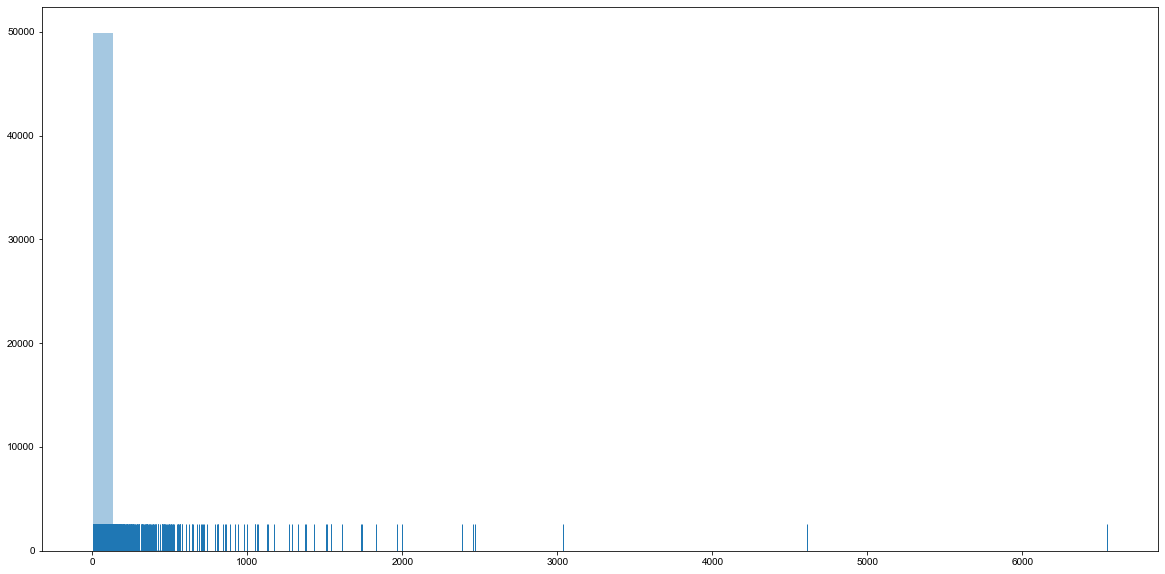

In [18]:
# histogram
sns.distplot(conditions, kde=False, rug=True)

In [16]:
mesh_term = df.groupby('condition_browse/mesh_term', as_index=False).nct_id.count()
mesh_term.sort_values('nct_id', ascending=False).head(10)

,condition_browse/mesh_term,nct_id
1573,None,58494
576,Diabetes Mellitus,9102
281,Breast Neoplasms,6399
2157,Syndrome,6102
598,Disease,4931
323,Carcinoma,4660
1327,Lymphoma,4303
1312,Lung Neoplasms,3956
1090,Hypertension,3740
1155,Infection,3649


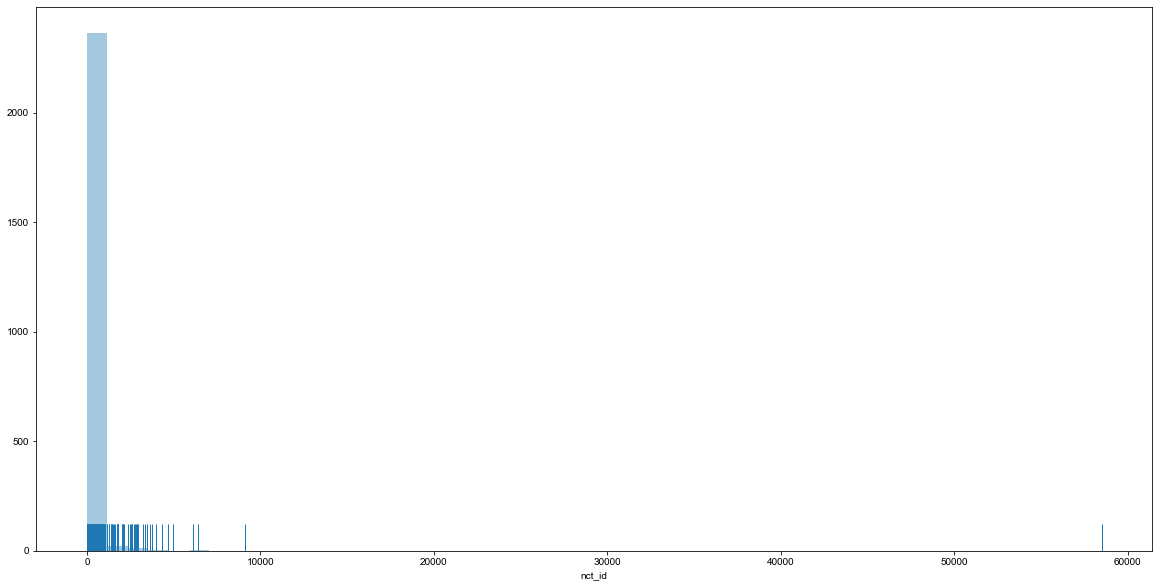

In [22]:
#histogram
sns.distplot(mesh_term.nct_id, kde=False, rug=True)

In [28]:
interventions = df.groupby('intervention_browse/mesh_term').nct_id.count()
interventions = pd.Series.to_frame(interventions)
interventions.sort_values('nct_id', ascending=False).head(10)

,nct_id
intervention_browse/mesh_term,
None,169063
Vaccines,5632
Insulin,2858
Paclitaxel,2741
Vitamins,2439
Anesthetics,2392
Pharmaceutical Solutions,2242
Cyclophosphamide,2039
Cisplatin,2033


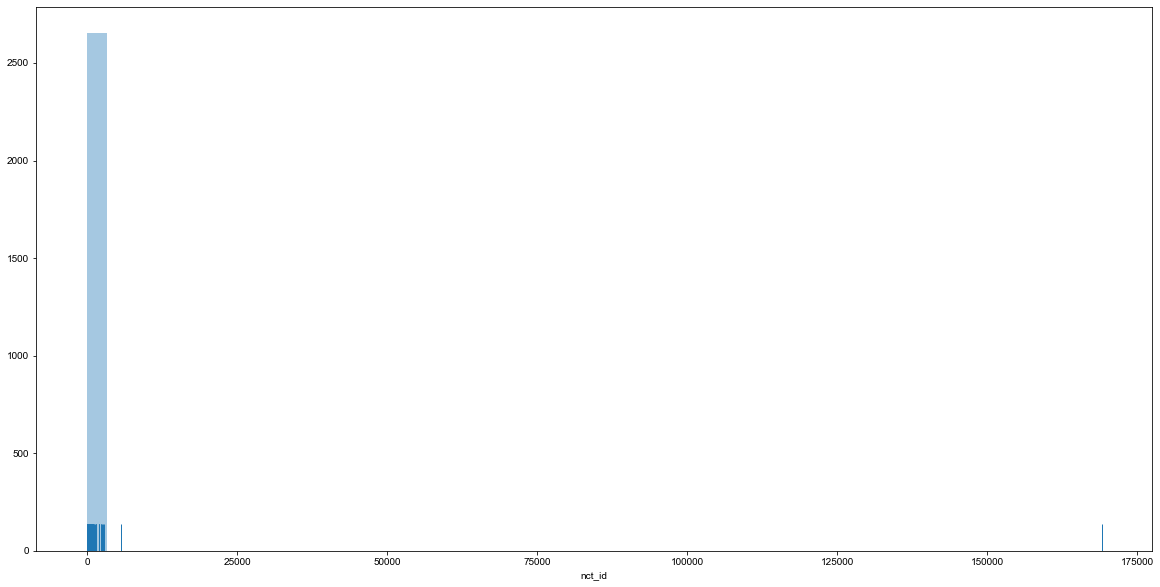

In [29]:
#histogram
sns.distplot(interventions.nct_id, kde=False, rug=True)

In [30]:
print(len(mesh_term))
print(len(conditions))
print(len(interventions))

2411
50164
2655


## Test 1: Cisplatin

In [56]:
cisplatin = df[df['intervention_browse/mesh_term'] == 'Cisplatin']
len(cisplatin)

2033

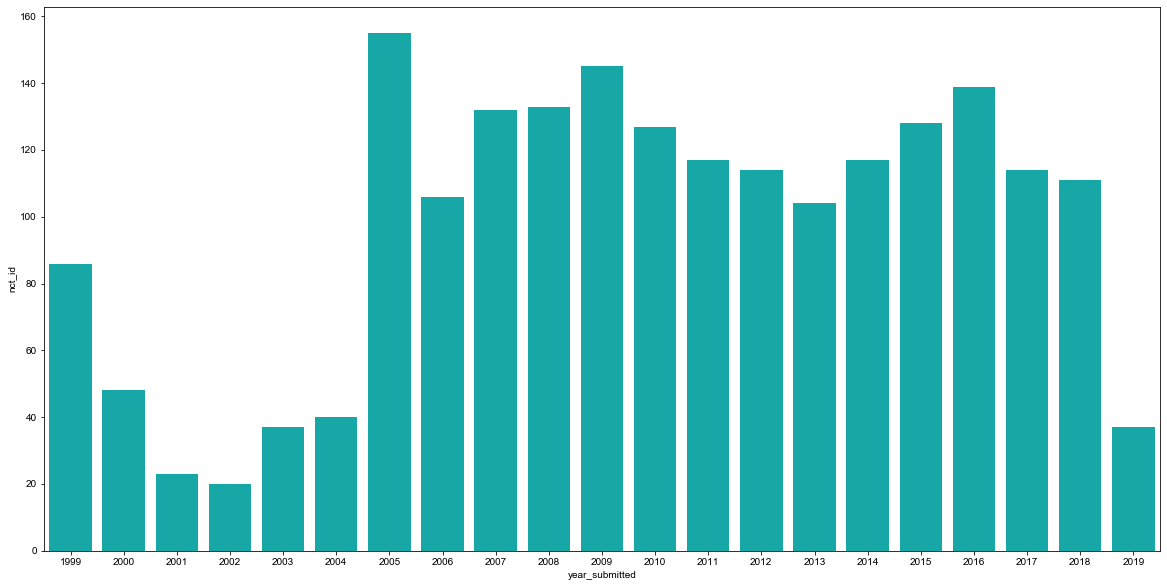

In [40]:
cisplatin_years = cisplatin.groupby('year_submitted').nct_id.count()
cisplatin_years = pd.Series.to_frame(cisplatin_years)
sns.barplot(x=cisplatin_years.index, y=cisplatin_years.nct_id, data=cisplatin_years, color='c')

In [49]:
# Full context for cisplatin (test search)
print(cisplatin.condition.nunique())
print(cisplatin['condition_browse/mesh_term'].nunique())
print(cisplatin['intervention_browse/mesh_term'].unique())

640
93
['Cisplatin']


## Test 2: Pain

In [55]:
pain = df[df['condition'] == 'Pain']
len(pain)

1741

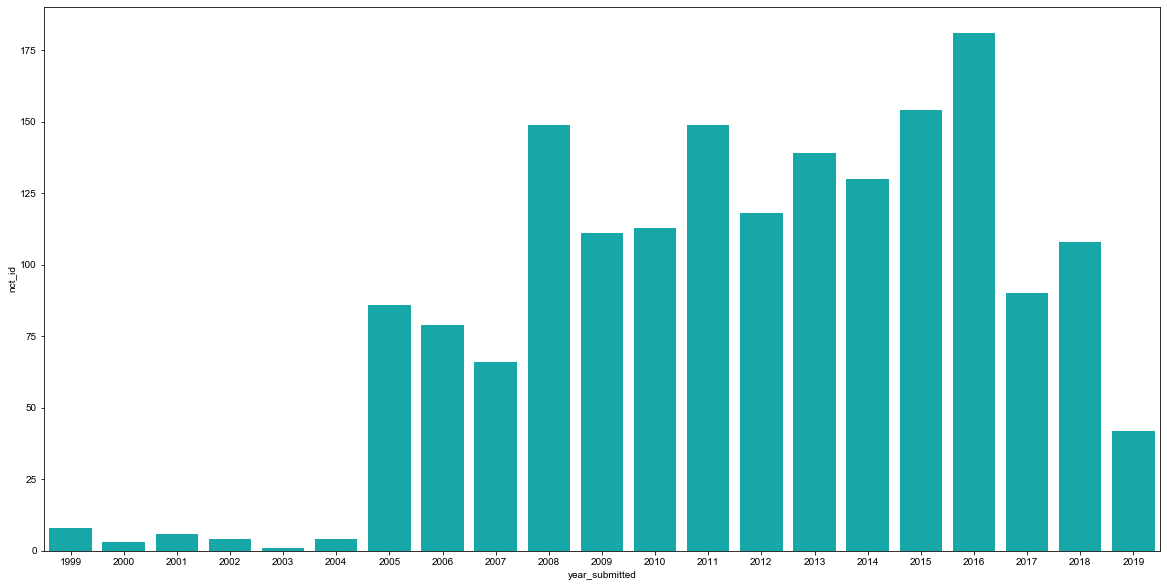

In [52]:
pain_years = pain.groupby('year_submitted').nct_id.count()
pain_years = pd.Series.to_frame(pain_years)
sns.barplot(x=pain_years.index, y=pain_years.nct_id, data=pain_years, color='c')

In [54]:
# Full context for cisplatin (test search)
print(pain.condition.nunique())
print(pain['condition_browse/mesh_term'].nunique())
print(pain['intervention_browse/mesh_term'].nunique())

1
162
146


## Test 3: Specific term in all_text

In [67]:
gen = df[df['all_text'].str.contains("RSV")]
len(gen)

310

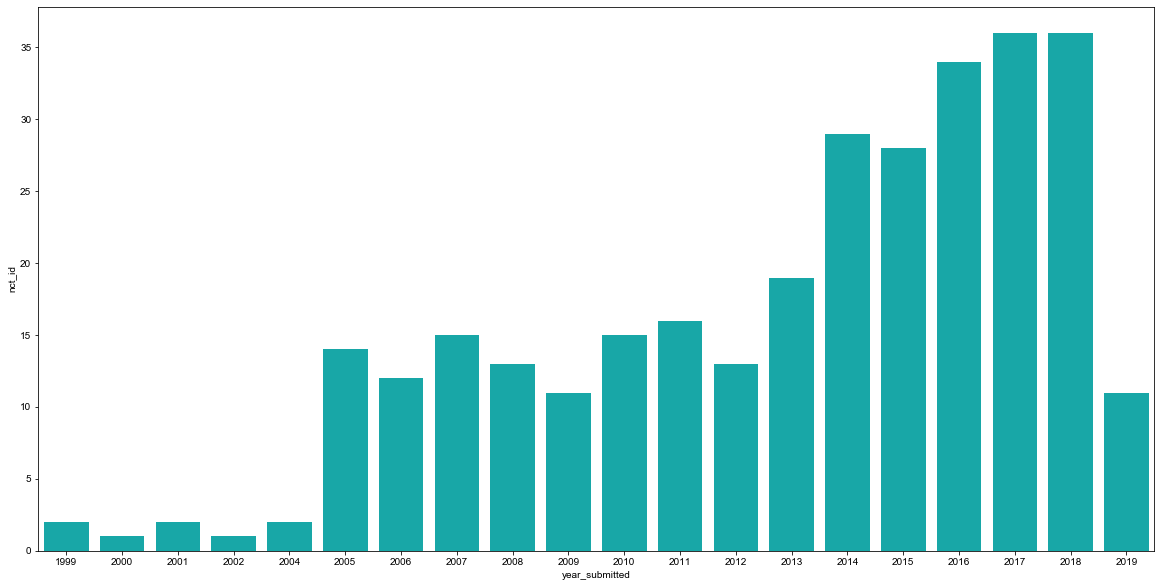

In [63]:
gen_years = gen.groupby('year_submitted').nct_id.count()
gen_years = pd.Series.to_frame(gen_years)
sns.barplot(x=gen_years.index, y=gen_years.nct_id, data=gen_years, color='c')

In [64]:
# Full context for cisplatin (test search)
print(gen.condition.nunique())
print(gen['condition_browse/mesh_term'].nunique())
print(gen['intervention_browse/mesh_term'].nunique())

114
52
40


In [91]:
print(gen['condition_browse/mesh_term'].unique())

['Virus Diseases' 'Bronchiolitis' 'None' 'Cough' 'Influenza, Human'
 'Pneumonia' 'Lung Diseases' 'Infection' 'Periodontitis'
 'Muscular Dystrophies' 'Arteriosclerosis' 'Asthma'
 'Coronary Artery Disease' 'Respiratory Syncytial Virus Infections'
 'Respiratory Insufficiency' 'Respiratory Tract Infections'
 'Muscular Diseases' 'Wounds and Injuries' 'Diabetes Mellitus'
 'Respiratory Sounds' 'Overweight' 'Melanoma' 'Encephalitis'
 'Disease Susceptibility' 'Premature Birth' 'Croup' 'Breast Neoplasms'
 'Refractive Errors' 'Dyspnea' 'Respiratory Aspiration' 'Meningitis'
 'Chronic Disease' 'Suicidal Ideation' 'Paramyxoviridae Infections'
 'Kidney Diseases' 'Pain, Postoperative' 'Emergencies' 'Heart Diseases'
 'Neoplasms' 'Syndrome' 'Prostatic Neoplasms' 'Sclerosis'
 'Brain Neoplasms' 'Coinfection' 'Infant Death' 'Furcation Defects'
 'Sepsis' 'Rhinitis' 'Bronchial Hyperreactivity' 'Heart Failure'
 'Inflammation' 'Metabolic Syndrome']


## Test 4: Pipeline

In [80]:
pipeline = df[df['source'].str.contains("Novartis")]
len(pipeline)

2742

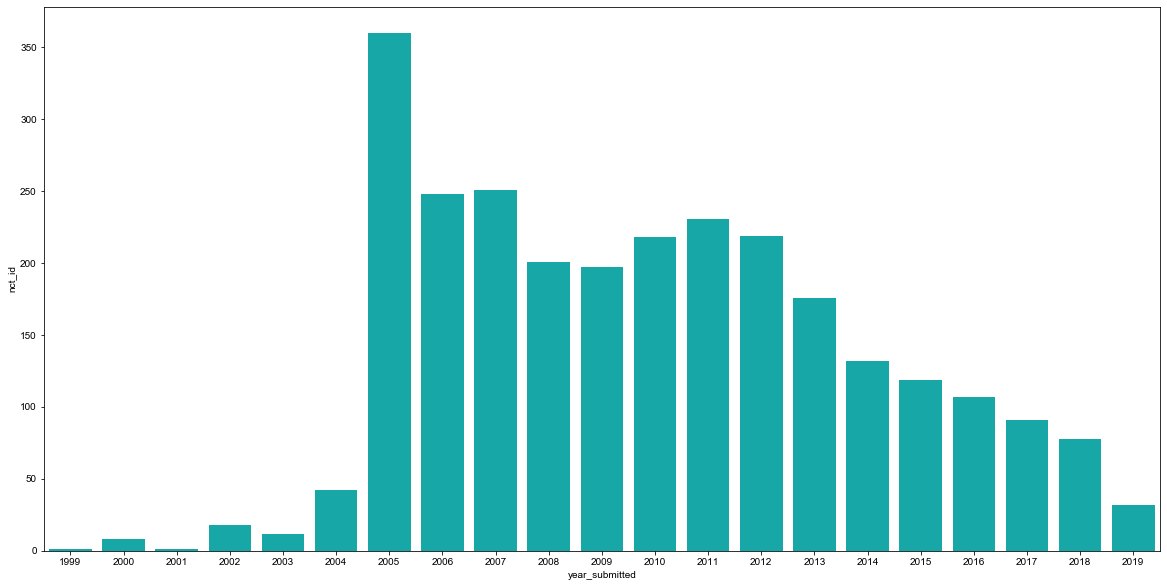

In [81]:
pipeline_years = pipeline.groupby('year_submitted').nct_id.count()
pipeline_years = pd.Series.to_frame(pipeline_years)
sns.barplot(x=pipeline_years.index, y=pipeline_years.nct_id, data=pipeline_years, color='c')

In [82]:
# Full context for pipeline (test search)
print(pipeline.condition.nunique())
print(pipeline['condition_browse/mesh_term'].nunique())
print(pipeline['intervention_browse/mesh_term'].nunique())

1055
267
262


In [83]:
pipeline_na = pipeline.dropna()
pipeline_phase = pipeline_na[pipeline_na['phase'].str.contains("Phase 3")]
len(pipeline_phase)

330

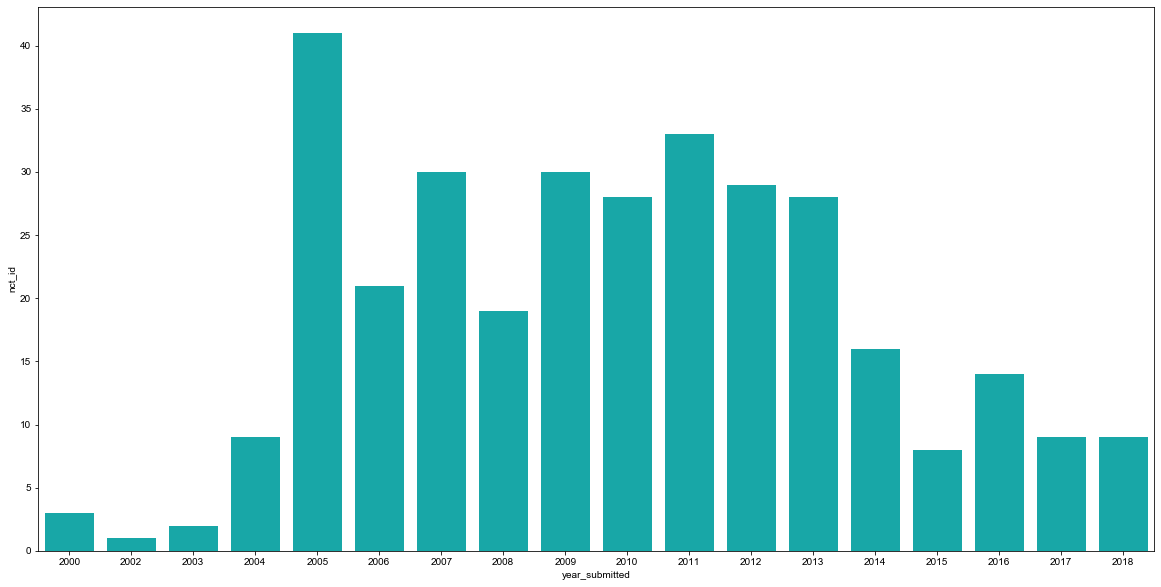

In [84]:
pipeline_phase_years = pipeline_phase.groupby('year_submitted').nct_id.count()
pipeline_phase_years = pd.Series.to_frame(pipeline_phase_years)
sns.barplot(x=pipeline_phase_years.index, y=pipeline_phase_years.nct_id, data=pipeline_phase_years, color='c')

In [85]:
# Full context for pipeline Phase 3
print(pipeline_phase.condition.nunique())
print(pipeline_phase['condition_browse/mesh_term'].nunique())
print(pipeline_phase['intervention_browse/mesh_term'].nunique())

210
103
108


## Machine Learning workflow
- Normalization: lowercasing, lemmatization, and stop-word removal
- TD-IDF by context

In [ ]:
# CountVectorizer